In [1]:
# Import các thư viện cần thiết
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy
import numpy as np
# Kiểm tra xem có CUDA (GPU) có sẵn không
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Kích thước mong muốn của hình ảnh đầu ra
imsize = 512 if torch.cuda.is_available() else 128  # sử dụng kích thước nhỏ nếu không có GPU


In [2]:
# Helper function: tải hình ảnh và chuyển thành tensor
def image_loader(image_name):
    loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])  
    image = Image.open(image_name)
    # Thêm chiều giả cho batch để phù hợp với input của mạng
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Helper function: hiển thị tensor dưới dạng hình ảnh PIL
def imshow(tensor, title=None):
    unloader = transforms.ToPILImage()  # chuyển đổi lại thành hình ảnh PIL
    image = tensor.cpu().clone()  # sao chép tensor để không thay đổi nó
    image = image.squeeze(0)      # loại bỏ chiều giả của batch
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # tạm dừng một chút để cập nhật đồ thị


In [3]:
# Lớp ContentLoss: Tính toán mất mát giữa ảnh nội dung và ảnh mục tiêu
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# Hàm gram_matrix: Tính toán ma trận Gram cho ảnh style
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    features = input.view(a * b, c * d)  # thay đổi kích thước
    G = torch.mm(features, features.t())  # tính toán ma trận Gram
    return G.div(a * b * c * d)

# Lớp StyleLoss: Tính toán mất mát giữa ảnh style và ảnh mục tiêu
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [4]:
# Lớp Normalization: Chuẩn hóa ảnh đầu vào cho mô hình VGG
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std


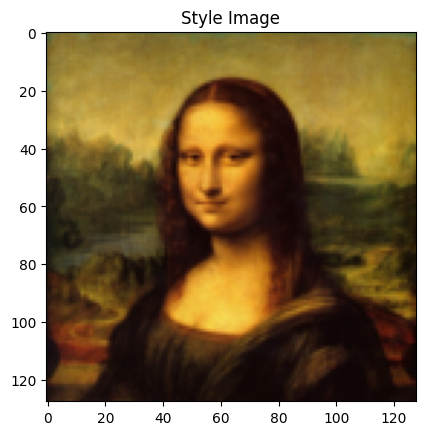

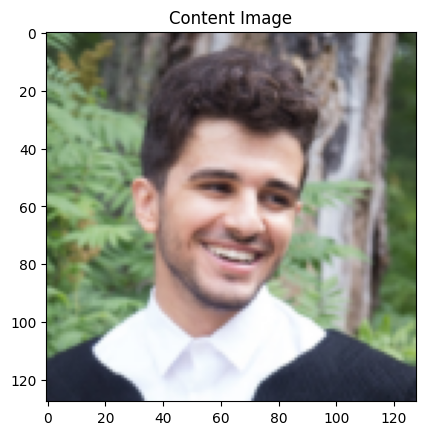

In [5]:
# Tải hình ảnh style và content
style_img = image_loader("C:\\Users\\Admin\\Downloads\\type3.jpg")
content_img = image_loader("C:\\Users\\Admin\\Downloads\\me.jpg")

# Kiểm tra kích thước của hình ảnh
assert style_img.size() == content_img.size(), "Hình ảnh style và content phải có kích thước giống nhau"

# Hiển thị hình ảnh style và content
plt.ion()
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')


In [6]:
# Tải mô hình VGG19 đã được huấn luyện từ ImageNet
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Các giá trị chuẩn hóa cho mô hình VGG19
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Hàm tạo mô hình với các lớp mất mát
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=['conv_4'],
                               style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


In [8]:
# Hàm tối ưu hóa input image
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# Hàm chạy neural style transfer
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img


Building the style transfer model..


C:\Users\Admin\AppData\Local\Temp\ipykernel_15080\3948300201.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15080\3948300201.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 237.321854 Content Loss: 20.456947

run [100]:
Style Loss : 76.226967 Content Loss: 21.411289

run [150]:
Style Loss : 43.417435 Content Loss: 20.785629

run [200]:
Style Loss : 27.913116 Content Loss: 20.769957

run [250]:
Style Loss : 20.588642 Content Loss: 20.012726

run [300]:
Style Loss : 12.733979 Content Loss: 17.571775



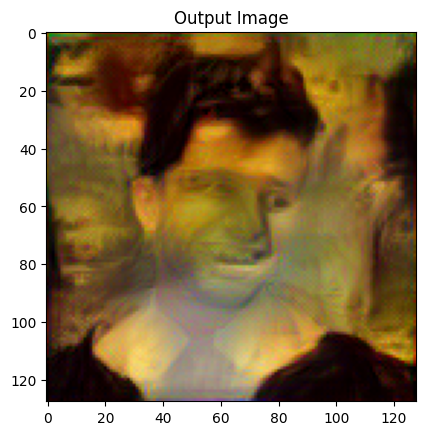

In [10]:
# Thực thi và hiển thị kết quả
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=300)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()
